# Challenge de Data Engineer

## Introducción
En el siguiente notebook se va a presentar un análisis del proceso resolutivo para el challenge de LATAM Airlines.
El notebook se divide en seis secciones que son:

1. Análisis preliminar de los datos 
2. Análisis de la solución
3. Análisis de los resultados 
4. Conclusiones


## 1. Análisis preliminar de los datos
Comenzamos cargando el dataset desde un archivo JSONL utilizando Pandas. Este paso es importante debido a que JSONL es eficiente para almacenar datos semiestructurados. Sin embargo, tiene algunas desventajas cuando se trabaja con grandes volúmenes de datos y si tiene estructuras anidadas el análisis se complejiza.

In [43]:
import pandas as pd

import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
jsonl_file = '../farmers-protest-tweets-2021-2-4.json'

df = pd.read_json(jsonl_file, lines=True)
print(df.head(5))

El tamaño del archivo JSONL es: 388.83 MB
                                                              url                      date                                                                                                                                                                                                                                                                                                            content                                                                                                                                                                                                                                                                                                    renderedContent                   id                                                                                                                                                                                                                                        

Tras revisar el archivo de datos, se identificaron las columnas clave necesarias para resolver los ejercicios planteados. Las columnas más importantes son: date, user, content y mentionedUsers. Estas columnas fueron seleccionadas en función de los requisitos de cada ejercicio:

-   Date y User: Son esenciales para resolver el ejercicio que solicita las 10 fechas con mayor cantidad de tweets, además de identificar el usuario con más publicaciones en cada una de esas fechas. La columna date almacena la fecha de los tweets, y user contiene el nombre del usuario, que necesitamos extraer.
-   Content: Esta columna es clave para el ejercicio que pide identificar los 10 emojis más usados, ya que almacena el contenido completo de cada tweet. A partir de content, podemos analizar y extraer los emojis presentes en los textos.
-   MentionedUsers: Para el ejercicio que requiere identificar a los 10 usuarios más influyentes basados en las menciones, mentionedUsers es crucial. Esta columna nos permite extraer directamente los usuarios mencionados en los tweets, y junto con user, podemos determinar quiénes son los usuarios con más menciones.

Al trabajar únicamente con las columnas que son relevantes para el análisis, no solo simplifica el código, sino que también mejora el rendimiento. Esto se debe a que, al reducir la cantidad de datos que se procesan, se minimiza el uso de memoria y acelera el tiempo de ejecución.

In [32]:
columns_of_interest = ['date', 'user', 'content', 'mentionedUsers']
print("Columnas presentes en el archivo:")
print(df.columns)
print("\nContenido de las columnas 'date', 'user', 'content', 'mentionedUsers':")
print(df[columns_of_interest].head())

Columnas presentes en el archivo:
Index(['url', 'date', 'content', 'renderedContent', 'id', 'user', 'outlinks',
       'tcooutlinks', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel', 'media',
       'retweetedTweet', 'quotedTweet', 'mentionedUsers'],
      dtype='object')

Contenido de las columnas 'date', 'user', 'content', 'mentionedUsers':
                       date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Al revisar los campos seleccionados para el análisis, encontramos que la columna user es un objeto JSON, mientras que la columna mentionedUsers contiene una lista de objetos JSON. Este tipo de estructuras anidadas complica el análisis, ya que exige un esfuerzo extra para poder utilizar los datos.

Para facilitar el análisis, se procederá a normalizar estas columnas, lo cual implicará extraer únicamente los atributos necesarios para resolver el challenge. En particular:

- Columna user: se extrae únicamente el atributo username, que es el identificador del usuario que publicó el tweet. Esto reduce el peso de los datos y simplifica las consultas.
- Columna mentionedUsers: se extrae una lista simple con los usuarios mencionados en cada tweet, eliminando la estructura de objetos anidados que no es necesaria para los análisis.

Tras simplificar las estructuras de los datos, se convierte el conjunto al formato Parquet, ya que es un formato columnar optimizado para análisis de grandes volúmenes de datos. A diferencia de JSONL, Parquet permite acceder solo a las columnas necesarias, reduciendo el tiempo de lectura y empleando compresión eficiente para ahorrar espacio en disco. Esto optimiza tanto el rendimiento como la escalabilidad, ya que minimiza el uso de memoria y facilita el procesamiento de datos.

In [60]:
from utils.data_conversion import extract_relevant_data

jsonl_file = '../farmers-protest-tweets-2021-2-4.json'
parquet_file_path = '../tweets.parquet'

extract_relevant_data(jsonl_file,parquet_file_path)

In [61]:
parquet_size = os.path.getsize(parquet_file_path)
parquet_size_mb = parquet_size / (1024 * 1024)

jsonl_size = os.path.getsize(jsonl_file)
jsonl_size_mb = jsonl_size / (1024 * 1024)

print(f"El tamaño del archivo Parquet es: {parquet_size_mb:.2f} MB y del JSONL es {jsonl_size_mb:.2f} MB")

El tamaño del archivo Parquet es: 12.27 MB y del JSONL es 388.83 MB


Al comprimir el JSONL a Parquet, seleccionando solo las columnas de interés y normalizándolas, se obtuvo una reducción del peso de un 96.84%. Como el archivo Parquet solo pesa 12 MB y es un formato columnar, existe una mayor flexibilidad al momento de leer el archivo.

Se visualizan las primeras 5 filas del parquet para ver cómo queda la normalización de datos.

In [62]:
df = pd.read_parquet(parquet_file_path)
df.head(5)

,date,username,content,mentionedUsers
0,2021-02-24 09:23:35,ArjunSinghPanam,The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF,"[narendramodi, DelhiPolice]"
1,2021-02-24 09:23:32,PrdeepNain,"#FarmersProtest \n#ModiIgnoringFarmersDeaths \n#ModiDontSellFarmers \n@Kisanektamorcha \nFarmers constantly distroying crops throughout India. \nReally, it's hearts breaking...we care about our crops like our children. And govt. agriculture minister is laughing on us🚜🌾WE WILL WIN💪 https://t.co/kLspngG9xE",[Kisanektamorcha]
2,2021-02-24 09:23:22,parmarmaninder,ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇਰੇ ਹਿਸਾਬ ਨਾਲ ਬਾਹਰ(ਪ੍ਰਦੇਸ਼) ਜਾਣ ਨਾਲੋਂ ਬਿਹਤਰ ਆ ਭਾਰਤ 'ਚ ਪੈਟਰੋਲ ਪੰਪ ਪਾ ਲਈਏ। 🤫🤫🤔🤔\n#FarmersProtest,[]
3,2021-02-24 09:23:16,anmoldhaliwal,@ReallySwara @rohini_sgh watch full video here https://t.co/wBPNdJdB0n\n#farmersprotest #NoFarmersNoFood https://t.co/fUsTOKOcXK,"[ReallySwara, rohini_sgh]"
4,2021-02-24 09:23:10,KotiaPreet,#KisanEktaMorcha #FarmersProtest #NoFarmersNoFood https://t.co/g9TYYBHQRH,[]


# 2. Análisis de la solución 

A continuación, se realizará un análisis de las soluciones solicitadas con sus respectivos enfoques.

Para la resolución de los ejercicios Q1 y Q3, opté por DuckDB debido a su capacidad para manejar grandes volúmenes de datos de manera más eficiente, sobre todo si lo comparamos con librerías como Pandas. Como DuckDB permite ejecutar consultas SQL directamente en memoria sobre archivos Parquet, el uso de recursos se ve reducido ya que se evita la carga completa del dataset. Además, DuckDB optimiza el plan de ejecución automáticamente, utilizando un motor de ejecución vectorizado que procesa los datos en bloques, maximizando la eficiencia.

### q1_time()

En la función q1_time, se optó por una única consulta SQL para obtener las 10 fechas con más tweets y el usuario con más publicaciones en cada una. Como se mencionó anteriormente, DuckDB optimiza automáticamente el plan de ejecución. Esto permite que todas las operaciones, como el agrupamiento por fechas y el ranking de usuarios, se realicen en una sola pasada sobre los datos, lo que minimiza los accesos innecesarios a memoria y disco. 

```python
def q1_time(file_path: str, num_threads: int = 4) -> List[Tuple[date, str]]:
    """Gets top 10 dates with most tweets and the user with highest tweets for each date using a single query."""
    con = None
    try:
        logger.info(f"Starting processing for file: {file_path} with {num_threads} threads")
        con = duckdb.connect(database=':memory:')
        con.execute(f"PRAGMA threads={num_threads};")

        query = f"""
        WITH TopDates AS (
            SELECT
                date_trunc('day', date) AS tweet_date,
                COUNT(*) AS tweet_count
            FROM read_parquet('{file_path}')
            GROUP BY tweet_date
            ORDER BY tweet_count DESC
            LIMIT 10
        ),
        RankedUsers AS (
            SELECT
                date_trunc('day', date) AS tweet_date,
                username,
                COUNT(*) AS tweet_count,
                ROW_NUMBER() OVER (PARTITION BY date_trunc('day', date) ORDER BY COUNT(*) DESC, username ASC) AS rn
            FROM read_parquet('{file_path}')
            GROUP BY tweet_date, username
        )
        SELECT TD.tweet_date, RU.username
        FROM TopDates TD
        JOIN RankedUsers RU ON TD.tweet_date = RU.tweet_date
        WHERE RU.rn = 1
        ORDER BY TD.tweet_count DESC;
        """

        results = con.execute(query).fetchall()

        if not results:
            logger.warning(f"No results found in the file: {file_path}")
            return []

        return results

    except Exception as e:
        logger.error(f"Error during processing: {e}")
        raise
    finally:
        if con:
            con.close()
```

In [63]:
from q1_time import q1_time
parquet_file_path = '../tweets.parquet'
results = q1_time(parquet_file_path)
for _ in results:
        print(_)

2024-10-29 21:00:44,169 - INFO - Starting processing for file: ../tweets.parquet with 4 threads


(datetime.date(2021, 2, 12), 'RanbirS00614606')
(datetime.date(2021, 2, 13), 'MaanDee08215437')
(datetime.date(2021, 2, 17), 'RaaJVinderkaur')
(datetime.date(2021, 2, 16), 'jot__b')
(datetime.date(2021, 2, 14), 'rebelpacifist')
(datetime.date(2021, 2, 18), 'neetuanjle_nitu')
(datetime.date(2021, 2, 15), 'jot__b')
(datetime.date(2021, 2, 20), 'MangalJ23056160')
(datetime.date(2021, 2, 23), 'Surrypuria')
(datetime.date(2021, 2, 19), 'Preetm91')


### q1_memory

En la función q1_memory, se optó por dividir el proceso en dos etapas para optimizar el uso de memoria. Primero, se ejecuta una consulta que crea una vista temporal (top_dates) con las 10 fechas que tienen el mayor número de tweets. 

```python
def q1_memory(file_path: str, num_threads: int = 1) -> List[Tuple[date, str]]:
    """Finds top 10 dates with most tweets and the user with highest tweets for each date."""
    con = None
    try:
        logger.info(f"Starting processing for file: {file_path} with {num_threads} threads")
        con = duckdb.connect(database=':memory:')
        con.execute(f"PRAGMA threads={num_threads};")

        con.execute(f"""
            CREATE TEMP VIEW top_dates AS
            SELECT 
                date_trunc('day', date) AS tweet_date,
                COUNT(*) AS tweet_count
            FROM read_parquet('{file_path}')
            GROUP BY tweet_date
            ORDER BY tweet_count DESC
            LIMIT 10;
        """)

        top_dates = con.execute("SELECT * FROM top_dates;").fetchall()

        if not top_dates:
            logger.warning(f"No tweet dates found in the file: {file_path}")
            return []

        results = []
        for tweet_date, _ in top_dates:
            try:
                top_user, _ = get_top_user_for_date(con, file_path, tweet_date)
                if top_user:
                    results.append((tweet_date, top_user))
            except Exception as e:
                logger.error(f"Failed to retrieve top user for date {tweet_date}: {e}")

        return results

    except Exception as e:
        logger.error(f"Error during processing: {e}")
        raise
    finally:
        if con:
            con.close()
```

Luego, la función get_top_user_for_date se encarga de identificar al usuario con más tweets en una fecha específica. Esta función utiliza una consulta SQL con una CTE que genera un ranking de usuarios para la fecha seleccionada, lo que permite seleccionar al usuario con más publicaciones.

```python
def get_top_user_for_date(
    con: duckdb.DuckDBPyConnection,
    file_path: str,
    tweet_date: date
) -> Tuple[Optional[str], int]:
    """Gets the user with the highest tweet count for a specific date."""
    try:
        query = f"""
        WITH RankedUsers AS (
            SELECT
                username,
                COUNT(*) AS tweet_count,
                ROW_NUMBER() OVER (ORDER BY COUNT(*) DESC, username ASC) as rn
            FROM read_parquet('{file_path}')
            WHERE date_trunc('day', date) = '{tweet_date}'
            GROUP BY username
            ORDER BY tweet_count DESC, username ASC
        )
        SELECT username, tweet_count
        FROM RankedUsers
        WHERE rn = 1
        """
        result = con.execute(query).fetchone()
        return (result[0], result[1]) if result else (None, 0)

    except Exception as e:
        logger.error(f"Error processing date {tweet_date}: {e}")
        raise
```
Se optó por un análisis dividido en consultas separadas para reducir la carga en memoria, procesando solo los subconjuntos relevantes de datos en cada paso.
P.D.: Las funciones se muestran en ese orden para efectos explicativos, pero el orden original se encuentra en el archivo q1_memory.py.

In [57]:
from q1_memory import q1_memory
parquet_file_path = '../tweets.parquet'
results = q1_memory(parquet_file_path)
for _ in results:
        print(_)

2024-10-29 20:04:06,164 - INFO - Starting processing for file: ../tweets.parquet with 1 threads


(datetime.date(2021, 2, 12), 'RanbirS00614606')
(datetime.date(2021, 2, 13), 'MaanDee08215437')
(datetime.date(2021, 2, 17), 'RaaJVinderkaur')
(datetime.date(2021, 2, 16), 'jot__b')
(datetime.date(2021, 2, 14), 'rebelpacifist')
(datetime.date(2021, 2, 18), 'neetuanjle_nitu')
(datetime.date(2021, 2, 15), 'jot__b')
(datetime.date(2021, 2, 20), 'MangalJ23056160')
(datetime.date(2021, 2, 23), 'Surrypuria')
(datetime.date(2021, 2, 19), 'Preetm91')


### q2_time 
Para q2 se optó por utilizar pyarrow y procesamiento paralelo. Dado que fue complejo manipular los emojis con expresiones regulares utilizando DuckDB, además no se pudo compatibilizar DuckDB con la librería emojis.

En la función q2_time se procesa el archivo parquet en paralelo para extraer los 10 emojis más utilizados.

```python
def q2_time(file_path: str) -> List[Tuple[str, int]]:
    """Returns top 10 most used emojis using parallel processing for speed optimization."""
    logger.info(f"Starting processing for file: {file_path}")

    if not isinstance(file_path, str):
        raise TypeError("File path must be a string")

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    try:
        table = pq.read_table(file_path, columns=['content'])

        if table.num_rows == 0:
            logger.warning(f"File is empty: {file_path}")
            return []

        contents = table['content'].to_pandas().astype(str).tolist()

        num_cpus = multiprocessing.cpu_count()
        num_processes = min(num_cpus * 2, 16)

        chunk_size = max(1, len(contents) // num_processes)
        chunks = [contents[i:i + chunk_size] for i in range(0, len(contents), chunk_size)]

        with ProcessPoolExecutor(max_workers=num_processes) as executor:
            counters = list(executor.map(process_chunk, chunks))

        final_counter = Counter()
        for counter in counters:
            final_counter.update(counter)

        result = final_counter.most_common(10)

        for emoji_char, count in result:
            if not isinstance(emoji_char, str) or not isinstance(count, int):
                raise ValueError("Invalid data types in result")

        logger.info("Processing completed successfully")
        return result

    except pq.lib.ArrowInvalid:
        logger.error(f"Invalid Parquet file: {file_path}")
        raise ValueError("Invalid or corrupted Parquet file")
    except Exception as e:
        logger.error(f"Error during processing: {e}")
        raise RuntimeError(f"Unexpected error: {e}")
```

En process_chunk se procesan los tweets en grupos y se cuentan los emojis mediante Counter.

```python
def process_chunk(contents: List[str]) -> Counter:
    """Process a chunk of tweets and count emojis."""
    chunk_counter = Counter()
    for content in contents:
        if content:
            chunk_counter.update(extract_emojis_from_content(content))
    return chunk_counter
```

Finalmente, en extract_emojis_from_content se extraen los emojis del contenido utilizando la librería emojis.

```python
def extract_emojis_from_content(content: str) -> List[str]:
    """Extracts emojis from text content."""
    if not isinstance(content, str):
        return []
    return [d['emoji'] for d in emoji.emoji_list(content)] if content else []
```

In [64]:
from q2_time import q2_time
parquet_file_path = '../tweets.parquet'
results = q2_time(parquet_file_path)
for _ in results:
        print(_)

2024-10-29 21:00:55,607 - INFO - Starting processing for file: ../tweets.parquet
2024-10-29 21:00:58,545 - INFO - Processing completed successfully


('🙏', 5049)
('😂', 3072)
('🚜', 2972)
('🌾', 2182)
('🇮🇳', 2086)
('🤣', 1668)
('✊', 1651)
('❤️', 1382)
('🙏🏻', 1317)
('💚', 1040)


### q2_memory

El enfoque de q2_memory utiliza procesamiento por lotes (batch processing) para optimizar el uso de memoria.

Inicialmente se procesa el archivo parquet iterando en batches, sin la necesidad de cargar todo el dataset a la vez.

```python
def q2_memory(file_path: str, batch_size: int = 10000) -> List[Tuple[str, int]]:
    """Returns top 10 most used emojis and their counts, optimized for memory usage."""
    logger.info(f"Starting processing for file: {file_path}")
    emoji_counter = Counter()
    processed_rows = 0

    try:
        with create_parquet_iterator(file_path, batch_size) as iterator:
            for batch in iterator:
                update_counter_from_batch(batch, emoji_counter)
                processed_rows += batch.num_rows

                if processed_rows % (batch_size * 10) == 0:
                    logger.info(f"Processed {processed_rows:,} records")

        logger.info(f"Processing completed. Total records: {processed_rows:,}")
        return emoji_counter.most_common(10)

    except Exception as e:
        logger.error(f"Error processing file: {e}")
        raise
```

En update_counter_from_batch se actualiza de manera eficiente el contador ya que los tweets se están cargando por lotes.

```python
def update_counter_from_batch(batch, emoji_counter: Counter) -> None:
    """Updates emoji counter with emojis from a batch of records."""
    for content in batch['content']:
        if content is not None:
            content_str = str(content.as_py())
            emoji_counter.update(extract_emojis(content_str))
```

En extract_emojis se extraen los emojis del contenido utilizando la librería emojis.

```python
def extract_emojis(content: str) -> Generator[str, None, None]:
    """Extracts emojis from tweet content."""
    if content and isinstance(content, str):
        for emoji_dict in emoji.emoji_list(content):
            yield emoji_dict['emoji']

```

In [65]:
from q2_memory import q2_memory
parquet_file_path = '../tweets.parquet'
results = q2_memory(parquet_file_path)
for _ in results:
        print(_)

2024-10-29 21:01:06,153 - INFO - Starting processing for file: ../tweets.parquet
2024-10-29 21:01:16,596 - INFO - Processed 100,000 records
2024-10-29 21:01:18,314 - INFO - Processing completed. Total records: 117,407


('🙏', 5049)
('😂', 3072)
('🚜', 2972)
('🌾', 2182)
('🇮🇳', 2086)
('🤣', 1668)
('✊', 1651)
('❤️', 1382)
('🙏🏻', 1317)
('💚', 1040)


### q3_time 

En q3 se opta por reutilizar la misma estrategia que q1, es decir, por su capacidad y eficiencia para manejar grandes volúmenes de datos.

En la función q3_time, se usa una única consulta SQL para obtener los 10 usuarios más mencionados. Al desanidar, agrupar y ordenar los datos en una sola operación, se aprovechan las capacidades de DuckDB para ejecutar todo el proceso de manera eficiente en una sola pasada de los datos, en lugar de hacerlo en múltiples consultas o etapas. Como se mencionó previamente, DuckDB optimiza de manera automática el plan de ejecución.

```python
def q3_time(file_path: str) -> List[Tuple[str, int]]:
    """Returns top 10 most mentioned users using time-optimized single query processing."""
    try:
        logger.info(f"Starting processing for file: {file_path}")

        with duckdb.connect(database=':memory:') as con:
            query = """
            SELECT 
                mentioned_user AS username,
                COUNT(*) AS mention_count
            FROM (
                SELECT 
                    UNNEST(mentionedUsers) AS mentioned_user
                FROM read_parquet(?)
                WHERE mentionedUsers IS NOT NULL
            )
            GROUP BY username
            ORDER BY mention_count DESC, username ASC
            LIMIT 10;
            """

            results = con.execute(query, [file_path]).fetchall()

        logger.info("Processing completed successfully")
        return results

    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        raise
    except duckdb.BinderException as e:
        logger.error(f"Error in file structure or query: {e}")
        raise
    except Exception as e:
        logger.error(f"Error during processing: {e}")
        raise

```

In [66]:
from q3_time import q3_time
parquet_file_path = '../tweets.parquet'
results = q3_time(parquet_file_path)
for _ in results:
        print(_)

2024-10-29 21:01:22,601 - INFO - Starting processing for file: ../tweets.parquet
2024-10-29 21:01:22,686 - INFO - Processing completed successfully


('narendramodi', 2265)
('Kisanektamorcha', 1840)
('RakeshTikaitBKU', 1644)
('PMOIndia', 1427)
('RahulGandhi', 1146)
('GretaThunberg', 1048)
('RaviSinghKA', 1019)
('rihanna', 986)
('UNHumanRights', 962)
('meenaharris', 926)


### q3_memory

Finalmente, en la función q3_memory, se optó por utilizar la misma estrategia que en q1_memory, dividir el proceso en varias etapas. Primeramente se orquesta el proceso para obtener el top 10 de los usuarios más mencionados.

```python
def q3_memory(file_path: str) -> List[Tuple[str, int]]:
    """Returns top 10 most mentioned users using memory-optimized processing."""
    try:
        logger.info(f"Starting processing for file: {file_path}")

        with duckdb.connect(database=':memory:') as con:            
            get_flattened_mentions(con, file_path)
            results = get_mention_counts(con)

            mention_counts = Counter({username: count for username, count in results})
            top_mentions = mention_counts.most_common(10)

            logger.info("Processing completed successfully")
            return top_mentions

    except FileNotFoundError:
        logger.error(f"File not found: {file_path}")
        raise
    except duckdb.BinderException as e:
        logger.error(f"Error in file structure or query: {e}")
        raise
    except Exception as e:
        logger.error(f"Error during processing: {e}")
        raise
```

La función get_flattened_mentions se enfoca en crear una vista con todos los usuarios mencionados.

```python
def get_flattened_mentions(con: duckdb.DuckDBPyConnection, file_path: str) -> None:
    """Creates a temporary view of flattened user mentions."""
    query = f"""
    CREATE TEMP VIEW flattened_mentions AS
    SELECT 
        UNNEST(mentionedUsers) AS username
    FROM read_parquet('{file_path}')
    WHERE mentionedUsers IS NOT NULL;
    """
    con.execute(query)
```

Y por último, la función get_mention_counts, a través de la vista creada en get_flattened_mentions, obtiene los 10 usuarios más mencionados.

```python
def get_mention_counts(con: duckdb.DuckDBPyConnection) -> List[Tuple[str, int]]:
    """Gets top 10 users by mention count."""
    query = """
    SELECT 
        username,
        COUNT(*) AS mention_count
    FROM flattened_mentions
    GROUP BY username
    ORDER BY mention_count DESC, username ASC
    LIMIT 10;
    """
    return con.execute(query).fetchall()
```

En resumen, en la función q3_memory, el procesamiento se divide en dos consultas: una para crear una vista temporal con las menciones desanidadas y otra para contar las menciones por usuario, optimizando el uso de memoria. Esta separación permite trabajar solo con los datos esenciales en cada etapa. Sin contar que DuckDB reutiliza eficientemente las vistas temporales, lo que reduce la materialización de resultados intermedios y minimiza el consumo de memoria durante todo el proceso.

In [67]:
from q3_memory import q3_memory
parquet_file_path = '../tweets.parquet'
results = q3_memory(parquet_file_path)
for _ in results:
        print(_)

2024-10-29 21:01:27,755 - INFO - Starting processing for file: ../tweets.parquet
2024-10-29 21:01:27,836 - INFO - Processing completed successfully


('narendramodi', 2265)
('Kisanektamorcha', 1840)
('RakeshTikaitBKU', 1644)
('PMOIndia', 1427)
('RahulGandhi', 1146)
('GretaThunberg', 1048)
('RaviSinghKA', 1019)
('rihanna', 986)
('UNHumanRights', 962)
('meenaharris', 926)


#   3. Análisis de resultados

En esta sección se presentan los resultados obtenidos al comparar las funciones con su respectivos enfoques.

2024-10-29 01:55:18,892 - INFO - Starting processing for file: ../tweets.parquet with 4 threads
2024-10-29 01:55:19,546 - INFO - Starting processing for file: ../tweets.parquet with 4 threads
2024-10-29 01:55:20,175 - INFO - Starting processing for file: ../tweets.parquet with 1 threads
2024-10-29 01:55:20,877 - INFO - Starting processing for file: ../tweets.parquet with 1 threads


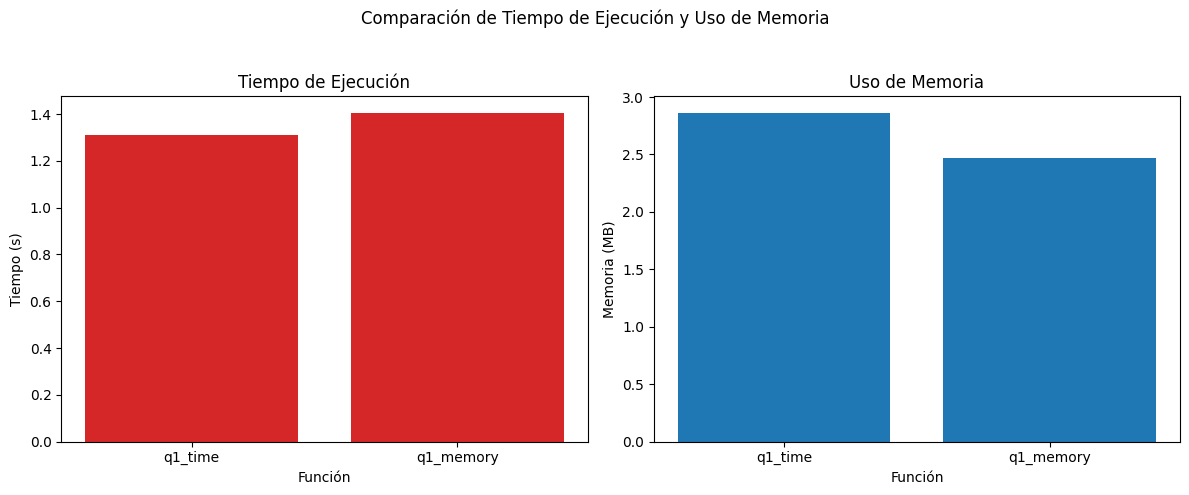

In [55]:
from utils.plot import plot_profile_results
from utils.profiling import profile_function

q1_time_execution_time, q1_time_max_memory, _ = profile_function(q1_time, parquet_file_path)
q1_memory_execution_time, q1_memory_max_memory, _ = profile_function(q1_memory, parquet_file_path)

function_names = ['q1_time', 'q1_memory']
execution_times = [q1_time_execution_time, q1_memory_execution_time]
memory_usages = [q1_time_max_memory, q1_memory_max_memory]

plot_profile_results(function_names, execution_times, memory_usages)

Al analizar los resultados de las funciones q1, no se observan diferencias significativas en el tiempo de ejecución entre ambos enfoques; sin embargo, sí se evidencia una distinción en cuanto al consumo de memoria. En este caso, DuckDB implementó una optimización en el plan de ejecución que resultó en un uso más eficiente de los recursos de memoria, demostrando las ventajas de su motor de procesamiento.

2024-10-29 21:01:41,977 - INFO - Starting processing for file: ../tweets.parquet
2024-10-29 21:01:44,810 - INFO - Processing completed successfully
2024-10-29 21:01:45,441 - INFO - Starting processing for file: ../tweets.parquet
2024-10-29 21:01:55,768 - INFO - Processed 100,000 records
2024-10-29 21:01:57,480 - INFO - Processing completed. Total records: 117,407


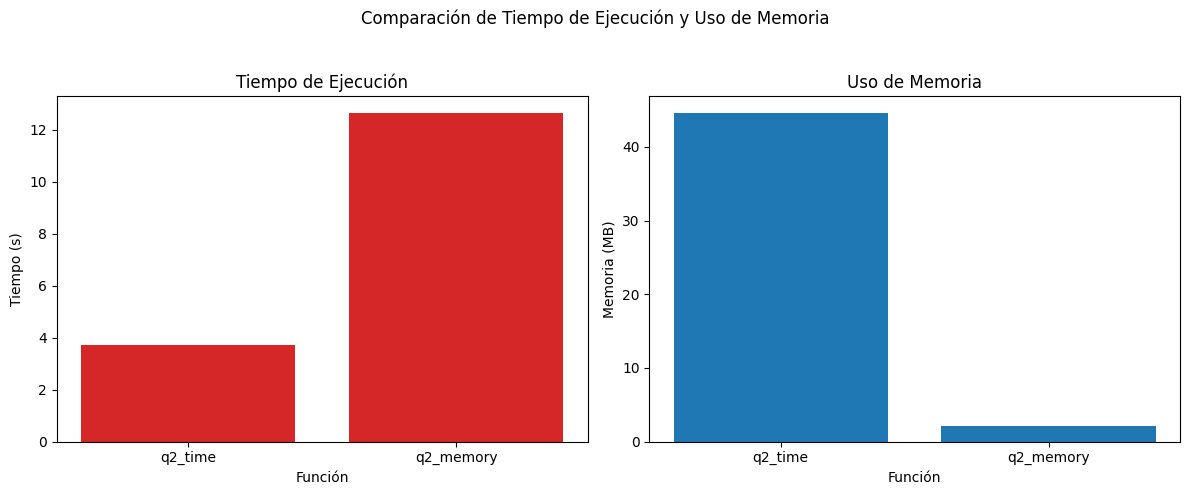

In [68]:
q2_time_execution_time, q2_time_max_memory, _ = profile_function(q2_time, parquet_file_path)
q2_memory_execution_time, q2_memory_max_memory, _ = profile_function(q2_memory, parquet_file_path)

function_names = ['q2_time', 'q2_memory']
execution_times = [q2_time_execution_time, q2_memory_execution_time]
memory_usages = [q2_time_max_memory, q2_memory_max_memory]

plot_profile_results(function_names, execution_times, memory_usages)

En contraste, en las funciones q2, sí se aprecia una diferencia significativa respecto a las métricas medidas en sus respectivos enfoques. Esto se debe a que en q2_memory se utiliza un enfoque basado en la carga por batches, lo que permite procesar los datos en fragmentos más pequeños en lugar de cargar el dataset completo en memoria. Por otro lado, q2_time es más rápida debido a que se carga el dataset completo, se permite realizar todas las operaciones de manera secuencial y directa, minimizando el tiempo de acceso a disco.

2024-10-28 22:21:13,259 - INFO - Starting processing for file: ../tweets.parquet
2024-10-28 22:21:13,338 - INFO - Processing completed successfully
2024-10-28 22:21:13,951 - INFO - Starting processing for file: ../tweets.parquet
2024-10-28 22:21:14,031 - INFO - Processing completed successfully
2024-10-28 22:21:14,646 - INFO - Starting processing for file: ../tweets.parquet
2024-10-28 22:21:14,725 - INFO - Processing completed successfully
2024-10-28 22:21:15,353 - INFO - Starting processing for file: ../tweets.parquet
2024-10-28 22:21:15,432 - INFO - Processing completed successfully


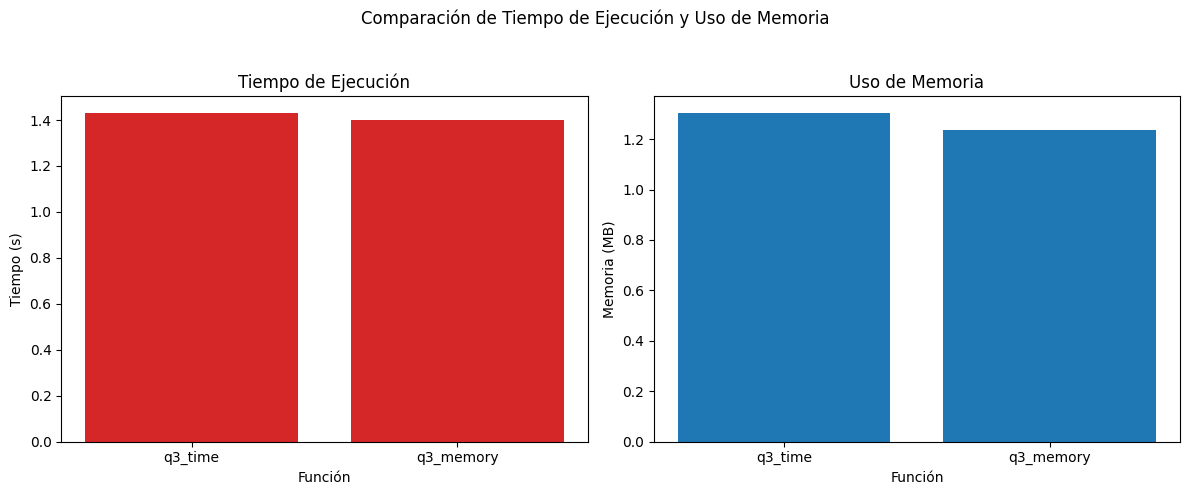

In [27]:
q3_time_execution_time, q3_time_max_memory, _ = profile_function(q3_time, parquet_file_path)
q3_memory_execution_time, q3_memory_max_memory, _ = profile_function(q3_memory, parquet_file_path)

function_names = ['q3_time', 'q3_memory']
execution_times = [q3_time_execution_time, q3_memory_execution_time]
memory_usages = [q3_time_max_memory, q3_memory_max_memory]

plot_profile_results(function_names, execution_times, memory_usages)

En este caso, DuckDB no pudo optimizar el uso de memoria como ocurre en Q1, debido a que se realiza de manera automática la optimización de memoria en el plan de ejecución. Cabe mencionar que DuckDB de manera automática prioriza y busca optimizar de forma simultánea tanto el consumo de memoria como el tiempo de ejecución. Además, al utilizar archivos en formato Parquet, estas optimizaciones se ven aún más potenciadas.

#### Comparacion de desempeño q1_memory utilizando un archivo JSONL vs Parquet

2024-10-29 01:26:07,733 - INFO - Starting processing for file: ../tweets.parquet with 1 threads
2024-10-29 01:26:08,459 - INFO - Starting processing for file: ../tweets.parquet with 1 threads


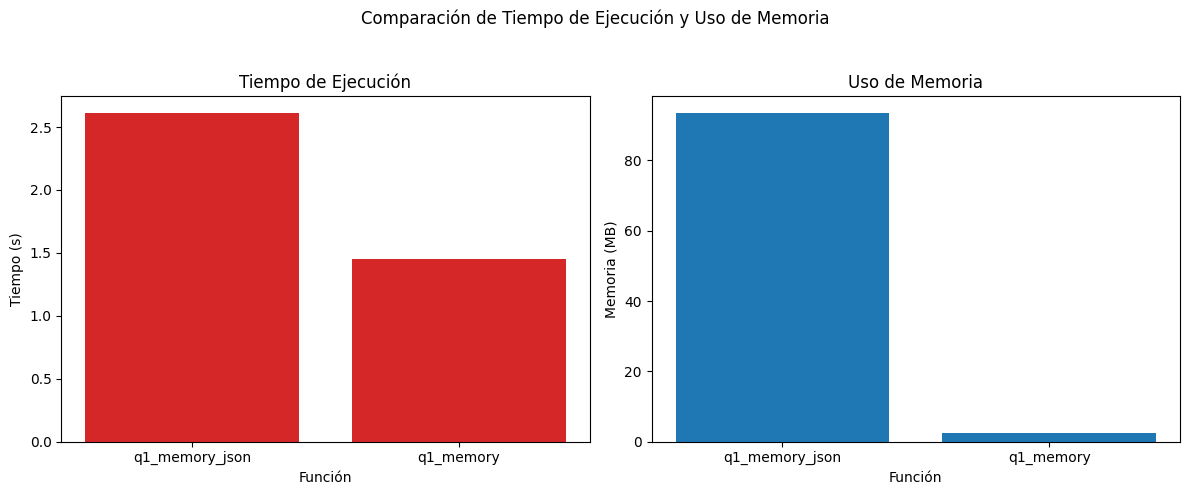

In [49]:
from utils.q1_memory_json import q1_memory_json


q1_memory_json_execution_time, q1_memory_json_max_memory, _ = profile_function(q1_memory_json, jsonl_file)
q1_memory_execution_time, q1_memory_max_memory, _ = profile_function(q1_memory, parquet_file_path)

function_names = ['q1_memory_json', 'q1_memory']
execution_times = [q1_memory_json_execution_time, q1_memory_execution_time]
memory_usages = [q1_memory_json_max_memory, q1_memory_max_memory]

plot_profile_results(function_names, execution_times, memory_usages)

Como se puede apreciar en la gráfica, existe una notable diferencia tanto en el tiempo como en el uso de memoria entre q1_memory con el uso de un archivo JSONL vs Parquet. Esto debido a que Parquet es un formato columnar optimizado para el almacenamiento y consulta de grandes volúmenes de datos. DuckDB puede leer solo las columnas necesarias sin cargar el archivo completo en memoria, lo que mejora el rendimiento y reduce el uso de recursos. En cambio, JSONL es un formato jerárquico y basado en texto, lo que requiere más procesamiento para desempaquetar y analizar las estructuras anidadas, haciendo que las consultas sean más lentas y menos eficientes en términos de memoria.

# 4. Conclusiones
Durante todo este análisis se pudo apreciar la importancia de trabajar con las tecnologías y herramientas adecuadas, además de validar la compatibilidad de estas y sacarle provecho a esta sinergia. El challenge inicialmente tiene como fuente de datos un archivo JSONL sin normalizar y con estructuras anidadas, pero haciendo un trabajo de normalización, compresión, y filtrado se obtuvo una reducción significativa en el tamaño del archivo, además de estar preparado para ser consumido en un contexto de análisis. Finalmente, la selección de DuckDB fue clave ya que se pudo sacar provecho del formato Parquet y solo requeriendo conocimiento en SQL, esto permitió tener tiempos de respuesta de alrededor de un segundo.